# Imports and other setup

In [1]:
# data processing
import pandas as pd
import numpy as np
from numpy import genfromtxt

# graphs / figures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

# sklearn / models
from sklearn.decomposition imp  ort PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# nltk
import nltk
from nltk.corpus import stopwords

# others
import os
import sys
sys.path.append('../')
from embedding_functions_hugo.embedding_functions import *
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from happytransformer import HappyTextClassification

def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

### Function for getting post_title, post_author, post_id, and the embedded title texts

In [3]:
def do_post_titles(df):
    texts, authors, post_ids = [], [], []
    title_author_set = set(zip(df['post_title'], df['post_author'], df['post_id']))

    for text, author, post_id in  title_author_set:
        texts.append(text)
        authors.append(author)
        post_ids.append(post_id)
    
    title_embeddings = embed_comments(texts)
    return pd.DataFrame(data=[post_ids, authors, texts, title_embeddings]).T.rename(columns={0 : 'post_id', 1: 'post_author', 2: 'post_title', 3: 'embeddings'})

### Getting final dataframe that we can use

In [4]:
def shorten_comment_text(df):
    '''Takes dataframe as input, shortens comment text, creates short_text column and removes comment_text column'''
    
    # getting all commenters that have also made a post
    shortened_df = df.query('comment_author in post_author').copy()

    # cleaning their comments and saving to new column
    clean_text = prep_pipeline(shortened_df, 'comment_text', loud=False)
    shortened_df['short_text'] = shorten_sens(clean_text, 50)
    shortened_df.drop('comment_text', axis=1, inplace=True)

    return shortened_df

In [5]:
def get_embed_pairs(df):
   '''Takes dataframe as input, combines all user title texts into one
      Returns embed_pairs'''
    
   # for each poster, appending all of their post text into one long string
   embed_pairs = {}
   for text, author in zip(df['post_title'], df['post_author']):
      if author not in embed_pairs.keys():
         embed_pairs[author] = text
      else:
         embed_pairs[author] += ' '+text

   return embed_pairs

def get_title_embeds(embed_pairs):
   '''Takes embed_pairs as input. Embeds the post titles and returns an array of them.'''

   # embedding all post titles and reducing them to 1 dimension
   embeds = dict(zip(embed_pairs.keys(), embed_comments(list(embed_pairs.values()))))
   embeds = reduce_to_one_dimension_kmeans(embeds)[-1]

   return embeds

In [249]:
def reduce_to_poster_commentors(df):
    '''given a df, reduces rows recursively until all commentors and posters are both commentors and posters'''

    # might be faster with doing query multiple times until no changes

    done = False
    initialized = False
    while done != True:

        comment_authors = list(df['comment_author'])
        post_authors = list(df['post_author'])

        if initialized == False:
            before = 0
            initialized = True
        else:
            before = len(users_to_include)

        users_to_include = set()

        after = 0

        for idx, row in df.iterrows():

            commentor = row[2]

            if commentor in post_authors:
                if commentor not in users_to_include:
                    # print(commentor)
                    users_to_include.add(commentor)
                    after += 1
            
            else:
                df.drop(idx, inplace=True)

        diff = after - before
        
        if diff == 0:
            print(f'before = {before} and after = {after}, so diff = {diff}, done!')
            done = True
        else:
            print(f'before = {before} and after = {after}, so diff = {diff}, relooping...')

    return df

# Creating Network

In [178]:
def create_network(df):
    '''Takes dataframe as input, creates a directed networkx network and returns it'''

    # Initializing text classification model
    model = HappyTextClassification(model_type='DISTILBERT', model_name='distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

    # initializing networkx directed graph
    G = nx.DiGraph()

    # # ensuring only looking at users that have both commented and posted
    # df = df.query('comment_author in post_author')

    print('doing embed_pairs')

    # combining users title texts into one
    embed_pairs = get_embed_pairs(df)

    print(len(embed_pairs))

    print('doing embeds')

    # embedding those combined title texts
    embeds = get_title_embeds(embed_pairs)

    print(len(embeds))

    # adding each post author as a node to network, with their 1 dimensional title embeddings as an attribute (named polarity)
    print('\n===== adding nodes ======\n')
    for i, j in zip(embed_pairs.keys(), embeds):
        print(f'added {i} with polarity {int(j)}')
        G.add_node(i, polarity = int(j))

    # getting list of user pairs for comments left on posts
    pairings = list(zip(df['comment_author'], df['post_author']))
    print(len(pairings))

    print('doing polarities')

    # classifying sentiments of comment texts and saving them in list "polarities"
    polarities = []
    for comment in df['short_text']:
        polarities.append(model.classify_text(comment).score)
    
    print(len(polarities))

    print('\n===== adding edges =====\n')
    # adding edges to graph, where each edge is a comment left by user a to user b, and its attribute is the sentiment of the comment
    for pair, polarity in zip(pairings, polarities):
        if pair[0] != pair[1]: # avoiding self edge connections
            print(f'adding edge from {pair[0]} to {pair[1]} with sentiment {polarity}')
            G.add_edge(u_of_edge=pair[0], v_of_edge=pair[1], attr=polarity)

    # drawing network
    nx.draw(G)

    return G

In [253]:
def full_pipeline(df):
    '''does everything and returns network'''
    # doing pre-network stuff
    df = reduce_to_poster_commentors(df)
    df = shorten_comment_text(df)

    # creating and drawing network
    G = create_network(df)

    return G

## Creating, initially inspecting and saving subreddits

Example filepath: '../data/19march/graphs/politics_network.gexf'

Make sure the filepath exists before running (manually create them) as otherwise it will take ~12 mins to run and end up giving an error

### r/politics - takes ~11 mins with 19march politics

before = 0 and after = 247, so diff = 247, relooping...
before = 247 and after = 235, so diff = -12, relooping...
before = 235 and after = 234, so diff = -1, relooping...
before = 234 and after = 234, so diff = 0, done!


03/28/2023 03:31:00 - INFO - happytransformer.happy_transformer -   Using model: cpu


doing embed_pairs
414
doing embeds


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 13/13 [38:10<00:00, 176.18s/it]
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


414

===== adding nodes ======

added bhodrolok with polarity 7
added Travismatthew08 with polarity 0
added newnemo with polarity 0
added Picture-unrelated with polarity -4
added Gari_305 with polarity 6
added LudovicoSpecs with polarity -6
added AnticAddict with polarity -4
added brezhnervous with polarity 4
added semaphore-1842 with polarity -2
added thisisinsider with polarity 2
added Beckles28nz with polarity 0
added PoliticsModeratorBot with polarity 1
added Hot-Bint with polarity -1
added MajesticOuting with polarity 0
added Surferino with polarity 0
added WalterBrannon with polarity 0
added BelleAriel with polarity 1
added LuvKrahft with polarity -5
added AreYouPurple with polarity 0
added mountaintop111 with polarity -1
added BubzerBlue with polarity 0
added bethashton with polarity 1
added pstbo with polarity 3
added BilBrowning with polarity 0
added luvddcups with polarity -5
added boregon with polarity 1
added prohb with polarity 0
added specqq with polarity 1
added ManchiBo

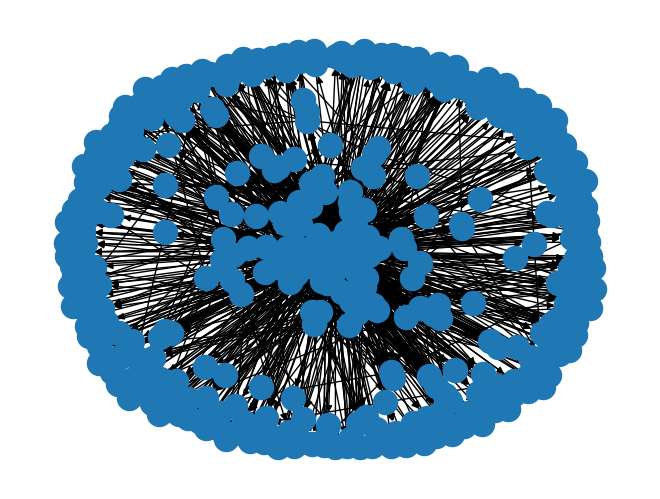

In [258]:
# grabbing scraped df
df_politics = pd.read_csv('../data/23march_chur/scrapes/politics.csv')

G_politics = full_pipeline(df_politics)

# saving network
nx.write_gexf(G_politics, '../data/23march_chur/graphs/politics.gexf')

### r/gaming

before = 0 and after = 285, so diff = 285, relooping...
before = 285 and after = 240, so diff = -45, relooping...
before = 240 and after = 230, so diff = -10, relooping...
before = 230 and after = 230, so diff = 0, done!


03/28/2023 04:45:46 - INFO - happytransformer.happy_transformer -   Using model: cpu


doing embed_pairs
508
doing embeds


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 16/16 [26:14<00:00, 98.40s/it]  
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


508

===== adding nodes ======

added PUSClFER with polarity -2
added nipplemeetssandpaper with polarity -5
added youwillcomedownsoon2 with polarity -1
added eru777 with polarity -5
added manoftheland100 with polarity -1
added -zero01one- with polarity -1
added xxxSexMan69xxx with polarity 0
added BenBeyaz with polarity 0
added HitokiriK with polarity 0
added landocharisma with polarity 0
added Gotsnuffy with polarity 0
added NabeelaTheArtist with polarity -5
added _Mr_Cheeks with polarity -2
added EvilCharizard with polarity -2
added 7eregrine with polarity -3
added SimonNeedsMemes with polarity 1
added johnlen1n with polarity 1
added KhazadNar with polarity 0
added Sarato88 with polarity -3
added Racika with polarity -3
added Mr_donc with polarity 0
added jemist101 with polarity -1
added my_witty_pseudonym with polarity 6
added ClanPsi609 with polarity 4
added Zargabath with polarity -2
added CrossingEden with polarity -2
added RayTracingOn with polarity -1
added PoopNDash with polar

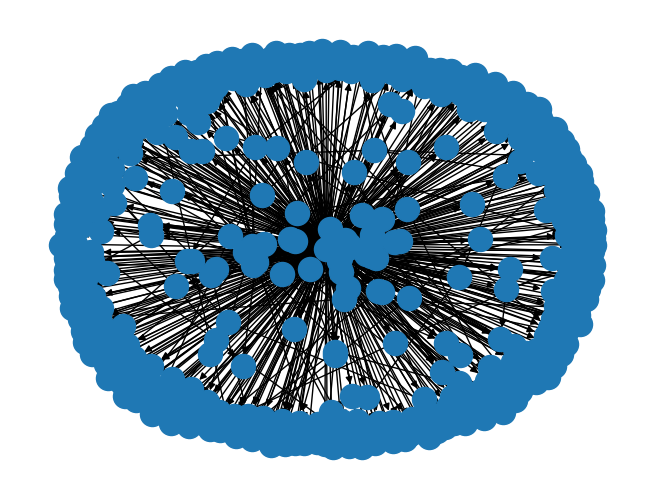

In [259]:
# grabbing scraped df
df_gaming = pd.read_csv('../data/23march_chur/scrapes/gaming.csv')

G_gaming = full_pipeline(df_gaming)

# saving network
nx.write_gexf(G_gaming, '../data/23march_chur/graphs/gaming.gexf')

### r/EscapefromTarkov

In [ ]:
# grabbing scraped df
df_tarkov = pd.read_csv('../data/19march/scrapes/EscapefromTarkov.csv')

# doing pre-network stuff
df_tarkov_shortened = shorten_comment_text(df_tarkov)

# creating and drawing network
G_tarkov = create_network(df_tarkov_shortened)

# saving network
nx.write_gexf(G_tarkov, '../data/19march/graphs/tarkov_network.gexf')

### r/HuntShowdown

In [ ]:
# grabbing scraped df
df_HuntShowdown = pd.read_csv('../data/19march/scrapes/HuntShowdown.csv')

# doing pre-network stuff
df_HuntShowdown_shortened = shorten_comment_text(df_HuntShowdown)

# creating and drawing network
G_HuntShowdown = create_network(df_HuntShowdown_shortened)

# saving network
nx.write_gexf(G_HuntShowdown, '../data/19march/graphs/HuntShowdown_network.gexf')